## Fuel cells data prediction
### Feature-generated method

##### The goal is to check whether featurization method can be used to predict the remaining useful life based on the data provided by *IEEE PHM 2014 Data Challenge*.
##### Since we know that there are only two sets of experimental results in the data set, each with 5 cells, in total 10 independent voltage time series curves, and the self-organizing map (SOM) does not work well with small number of samples based on our previous knowledge, so we would like to directly see if featurization method works.

Import all packages:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm
import sys, os

*Note: If section 1 and 2 are already runned before, there is no need to run them again. You can skip to section 3.*

### 1. Load the data


We load the raw data.
#
Since the current (density) is the same at all time in this data set ($J=0.70A/cm^2$), so only the columns of time (column 0) and voltage (column 1 to 5) arise our interest, and we will keep them.

In [2]:
f1_1 = open('IEEE 2014 Data Challenge Data/FC1_Without_Ripples/FC1_Ageing_part1.csv', 'r')
f1_2 = open('IEEE 2014 Data Challenge Data/FC1_Without_Ripples/FC1_Ageing_part2.csv', 'r')
f1_3 = open('IEEE 2014 Data Challenge Data/FC1_Without_Ripples/FC1_Ageing_part3.csv', 'r')
data1_1 = np.genfromtxt(f1_1,delimiter=",")
data1_1 = data1_1[~np.isnan(data1_1).any(axis=1)]
data1_2 = np.genfromtxt(f1_2,delimiter=",")
data1_2 = data1_2[~np.isnan(data1_2).any(axis=1)]
data1_3 = np.genfromtxt(f1_3,delimiter=",")
data1_3 = data1_3[~np.isnan(data1_3).any(axis=1)]
data1 = np.concatenate((data1_1, data1_2, data1_3), axis=0)[:,0:6]

f2_1 = open('IEEE 2014 Data Challenge Data/Full_FC2_With_Ripples/FC2_Ageing_part1.csv', 'r')
f2_2 = open('IEEE 2014 Data Challenge Data/Full_FC2_With_Ripples/FC2_Ageing_part2.csv', 'r')
data2_1 = np.genfromtxt(f2_1,delimiter=",")
data2_1 = data2_1[~np.isnan(data2_1).any(axis=1)]
data2_2 = np.genfromtxt(f2_2,delimiter=",")
data2_2 = data2_2[~np.isnan(data2_2).any(axis=1)]
data2 = np.concatenate((data2_1, data2_2), axis=0)[:,0:6]

Visualize the data:

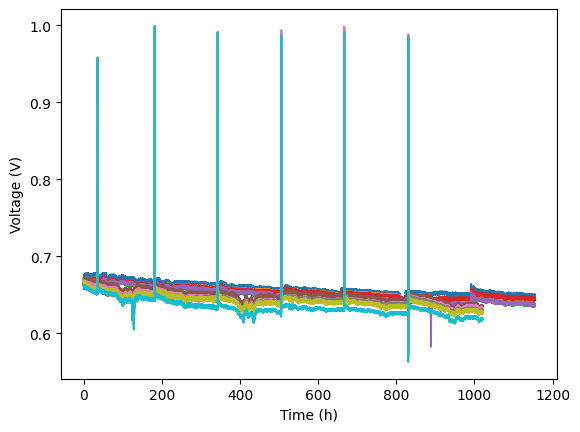

In [3]:
for column in range(1,6):
    plt.plot(data1[:,0],data1[:,column])

for column in range(1,6):
    plt.plot(data2[:,0],data2[:,column])

plt.xlabel('Time (h)')
plt.ylabel('Voltage (V)')
plt.show()

### 2. Preprocessing data

First remove some outliers (too large voltage at some time):

In [4]:
for column in range(1,6):
    Q1 = np.quantile(data1[:,column],0.25)
    Q3 = np.quantile(data1[:,column],0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    for i in range(1, len(data1[:,column])):
        if data1[i,column] > upper_bound:
            data1[i,column] = data1[i-1,column]

for column in range(1,6):
    Q1 = np.quantile(data2[:,column],0.25)
    Q3 = np.quantile(data2[:,column],0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    for i in range(1, len(data2[:,column])):
        if data2[i,column] > upper_bound:
            data2[i,column] = data2[i-1,column]

Visualize the data now:

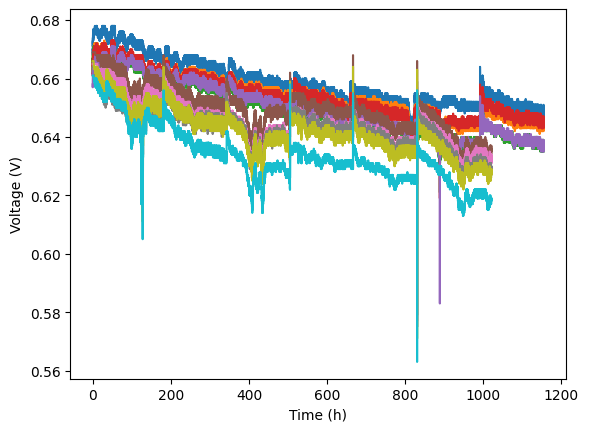

In [5]:
for column in range(1,6):
    plt.plot(data1[:,0],data1[:,column])

for column in range(1,6):
    plt.plot(data2[:,0],data2[:,column])

plt.xlabel('Time (h)')
plt.ylabel('Voltage (V)')
plt.show()

We see that large outliers are cleared, while all curves are still too noisy, so we apply Savitzky-Golay filter (https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html) with the length of the filter window (i.e., the number of coefficients) to be 1000 and the order of the polynomial used to fit the samples to be 2.

In [6]:
data1_filtered = data1.copy()

for column in range(1,6):
    data1_filtered[:,column] = savgol_filter(data1_filtered[:,column], 1000, 2)

data2_filtered = data2.copy()

for column in range(1,6):
    data2_filtered[:,column] = savgol_filter(data2_filtered[:,column], 1000, 2)

Visualize the filtered data now:

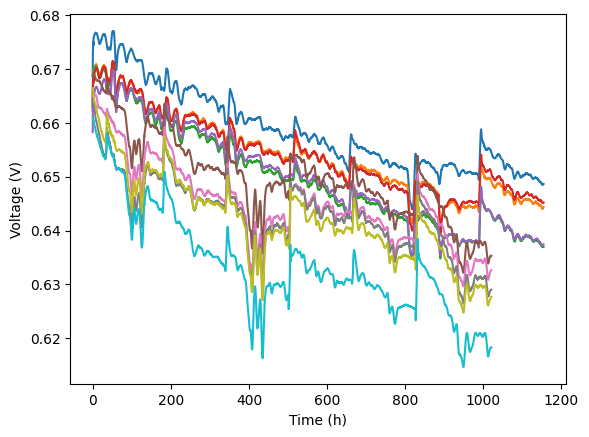

In [7]:
for column in range(1,6):
    plt.plot(data1_filtered[:,0],data1_filtered[:,column])

for column in range(1,6):
    plt.plot(data2_filtered[:,0],data2_filtered[:,column])

plt.xlabel('Time (h)')
plt.ylabel('Voltage (V)')
plt.show()

Now, normalizing all the data with respect to its initial voltage (maximal voltage) so that the curves will stay within 0 and 1 for better identification later.

In [8]:
data1_filtered_normalized = data1_filtered.copy()

for column in range(1,6):
    data1_filtered_normalized[:,column] = data1_filtered[:,column]/data1_filtered[:,column].max()

data2_filtered_normalized = data2_filtered.copy()

for column in range(1,6):
    data2_filtered_normalized[:,column] = data2_filtered[:,column]/data2_filtered[:,column].max()

Visualize the filtered and normalized data:

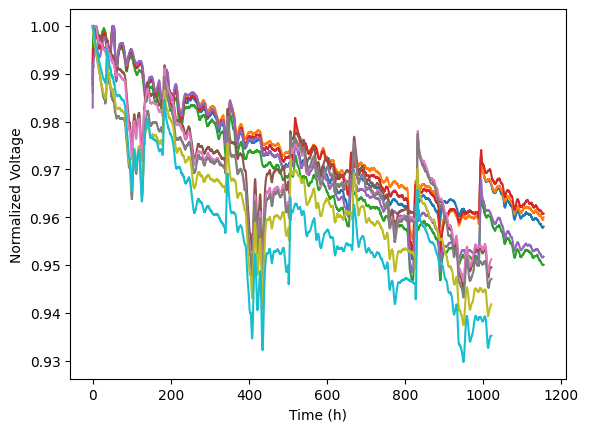

In [9]:
for column in range(1,6):
    plt.plot(data1_filtered_normalized[:,0],data1_filtered_normalized[:,column])

for column in range(1,6):
    plt.plot(data2_filtered_normalized[:,0],data2_filtered_normalized[:,column])

plt.xlabel('Time (h)')
plt.ylabel('Normalized Voltage')
plt.show()

Suppose that the failure threshold is defined as 95.5% of initial voltage. Then, in order to find the remaining useful life from Time=0 (h), we will now identify the time at which the normalized voltage reaches 0.955 for the first time for each test.

In [10]:
time_to_0_955_1 = []

for column in range(1,6):
    index = next(i for i, element in enumerate(data1_filtered_normalized[:,column]) if element < 0.955)
    time_to_0_955_1.append(data1_filtered_normalized[index,0])

time_to_0_955_2 = []

for column in range(1,6):
    index = next(i for i, element in enumerate(data2_filtered_normalized[:,column]) if element < 0.955)
    time_to_0_955_2.append(data2_filtered_normalized[index,0])

Check the identified time:

In [11]:
time_to_0_955_1

[810.3004736, 888.3923058, 807.5905794, 812.4146889, 808.8322628]

In [12]:
time_to_0_955_2

[405.54144, 400.3565672, 399.5008119, 395.742205, 387.2098125]

### 3. Featurizing the data
Assume that we only know the first 200 hours of testing, and we want to predict the remaining useful life until failure at 95.5% of initial voltage. So, for each cell in each experiment, we will calculate a number of "features" of interest from the timeseries data of the first 200 hours of testing and use them as input to linear and nonlinear models to predict lifetime.

In [13]:
# Define a convenience function that will calculate all the features and return them in a list, which is ready to be used as ML input
# The 9 Features are: [maximal voltage from 100 to 200 hours, minimal voltage from 0 to 100 hours and from 100 to 200 hours, variance, slope, and intercept of voltage from 0 to 100 hours and from 100 to 200 hours]

def featurize(time, voltage):
    features = []
    
    time1 = [x for x in time if x < 100]
    voltage1 = voltage[0:np.size(time1)]
    time2 = time[np.size(time1):-1]
    voltage2 = voltage[np.size(time1):-1]
    
    features.append(np.max(voltage2))
    features.append(np.min(voltage1))
    features.append(np.min(voltage2))
    features.append(np.var(voltage1))
    features.append(np.var(voltage2))
    
    slope1, intercept1 = np.polyfit(time1, voltage1, 1)
    slope2, intercept2 = np.polyfit(time2, voltage2, 1)
    features.append(slope1)
    features.append(intercept1)
    features.append(slope2)
    features.append(intercept2)
    
    return features

In [14]:
# Input (different features) is defined as X
X=[]
shortened_time=[x for x in data1_filtered_normalized[:,0] if x < 200]
for column in range(1,6):
    X.append(featurize(shortened_time,data1_filtered_normalized[0:np.size(shortened_time),column]))

shortened_time=[x for x in data2_filtered_normalized[:,0] if x < 200]
for column in range(1,6):
    X.append(featurize(shortened_time,data2_filtered_normalized[0:np.size(shortened_time),column]))

# Output (remaining useful life) is defined as y
y=np.concatenate((time_to_0_955_1, time_to_0_955_2))

### 4. Divide the data into the train set and the test set
We want 80% of the data to be the train set and the rest (20%) to be the test set.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 5. Build and test different models

#### (5.1) Linear model

In [16]:
model = LinearRegression()

# Now we use scikit learn to train a simple linear model
model.fit(X_train, y_train)

# And make predictions on the test set
y_pred = model.predict(X_test)

In [17]:
print('Predicted remaining useful life:',y_pred)
print('True remaining useful life:',y_test)
mape_temp = mean_absolute_percentage_error(y_test, y_pred)
print('Mean absolute percentage error:',mape_temp)

Predicted remaining useful life: [899.60856427 677.45506399]
True remaining useful life: [807.5905794 808.8322628]
Mean absolute percentage error: 0.13818480856986173


#### (5.2) Decision tree model

In [18]:
model = DecisionTreeRegressor(random_state=0)

#Now we use scikit learn to train a decision tree model using k-fold cross validation and grid search to find the best model with hyperparameters tunned

#First we define that we use 5 folds to conduct cross validation
skf = KFold(n_splits=5, random_state=10, shuffle=True)
#Then use grid search to tune for the best hyper parameters
model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
#Fit the model
model_search.fit(X_train, y_train)
#Get the best model
model = model_search.best_estimator_

# And make predictions on the test set
y_pred = model.predict(X_test)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-0.930, test=-4.561) neg_mean_squared_error: (train=-2.008, test=-26.793) total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-0.979, test=-11.758) neg_mean_squared_error: (train=-1.550, test=-181.466) total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-1.247, test=-43.312) neg_mean_squared_error: (train=-3.561, test=-3085.568) total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-1.729, test=-12.291) neg_mean_squared_error: (train=-7.186, test=-151.069) total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-1.522, test=-78.092) neg_mean_squared_error: (train=-6.984, test=-6098.334) total time=   0.0s
[CV 1/5] END criterion=squared_error, max_depth=

In [19]:
print('Predicted remaining useful life:',y_pred)
print('True remaining useful life:',y_test)
mape_temp = mean_absolute_percentage_error(y_test, y_pred)
print('Mean absolute percentage error:',mape_temp)

Predicted remaining useful life: [888.3923058 812.4146889]
True remaining useful life: [807.5905794 808.8322628]
Mean absolute percentage error: 0.052240983903688816


#### (5.3) Extremely randomized tree model (from *Feature engineering for machine learning enabled early prediction of battery lifetime*)
Extra-trees differ from classic decision trees in the way they are built. When looking for the best split to separate the samples of a node into two groups, random splits are drawn for each of the *max_features* randomly selected features and the best split among those is chosen. When *max_features* is set 1, this amounts to building a totally random decision tree.

In [20]:
model = ExtraTreeRegressor(random_state=0)

#Now we use scikit learn to train an extremely randomized tree model using k-fold cross validation and grid search to find the best model with hyperparameters tunned
model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
model_search.fit(X_train, y_train)
model = model_search.best_estimator_

# And make predictions on the test set
y_pred = model.predict(X_test)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-0.930, test=-203.437) neg_mean_squared_error: (train=-2.008, test=-81917.173) total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-0.979, test=-11.758) neg_mean_squared_error: (train=-1.550, test=-181.466) total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-1.247, test=-208.517) neg_mean_squared_error: (train=-3.561, test=-83472.880) total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-1.729, test=-1.046) neg_mean_squared_error: (train=-7.186, test=-1.094) total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-2.288, test=-75.978) neg_mean_squared_error: (train=-8.253, test=-5772.598) total time=   0.0s
[CV 1/5] END criterion=squared_error, max_de

In [21]:
print('Predicted remaining useful life:',y_pred)
print('True remaining useful life:',y_test)
mape_temp = mean_absolute_percentage_error(y_test, y_pred)
print('Mean absolute percentage error:',mape_temp)

Predicted remaining useful life: [405.54144   810.3004736]
True remaining useful life: [807.5905794 808.8322628]
Mean absolute percentage error: 0.24982652507395503


#### (5.4) Random forest model
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [22]:
model = RandomForestRegressor(random_state=0)

#Now we use scikit learn to train a random forest model using k-fold cross validation and grid search to find the best model with hyperparameters tunned
model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
model_search.fit(X_train, y_train)
model = model_search.best_estimator_

# And make predictions on the test set
y_pred = model.predict(X_test)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-20.053, test=-12.668) neg_mean_squared_error: (train=-1191.111, test=-179.359) total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-13.438, test=-15.961) neg_mean_squared_error: (train=-379.244, test=-283.715) total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-20.905, test=-16.441) neg_mean_squared_error: (train=-1420.847, test=-377.940) total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-12.544, test=-1.869) neg_mean_squared_error: (train=-354.594, test=-3.492) total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-7.062, test=-93.583) neg_mean_squared_error: (train=-78.220, test=-8757.816) total time=   0.0s
[CV 1/5] END criterion=squared_erro

In [23]:
print('Predicted remaining useful life:',y_pred)
print('True remaining useful life:',y_test)
mape_temp = mean_absolute_percentage_error(y_test, y_pred)
print('Mean absolute percentage error:',mape_temp)

Predicted remaining useful life: [793.36408479 812.51852697]
True remaining useful life: [807.5905794 808.8322628]
Mean absolute percentage error: 0.011086743858575736


#### (5.5) k-nearest neighbors model
The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.

In [24]:
model = KNeighborsRegressor(n_neighbors=2)

#Now we use scikit learn to train a k-nearest neighbors model using k-fold cross validation and grid search to find the best model with hyperparameters tunned
model_search = GridSearchCV(estimator=model, param_grid={'n_neighbors':np.arange(2,7), 'weights':['uniform', 'distance'], 'algorithm':['ball_tree', 'kd_tree', 'brute']}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
model_search.fit(X_train, y_train)
model = model_search.best_estimator_

# And make predictions on the test set
y_pred = model.predict(X_test)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END algorithm=ball_tree, n_neighbors=2, weights=uniform; neg_mean_absolute_error: (train=-15.846, test=-24.345) neg_mean_squared_error: (train=-522.052, test=-751.103) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, n_neighbors=2, weights=uniform; neg_mean_absolute_error: (train=-14.635, test=-5.348) neg_mean_squared_error: (train=-513.559, test=-54.242) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, n_neighbors=2, weights=uniform; neg_mean_absolute_error: (train=-15.576, test=-21.245) neg_mean_squared_error: (train=-495.879, test=-806.975) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=2, weights=uniform; neg_mean_absolute_error: (train=-13.267, test=-8.025) neg_mean_squared_error: (train=-442.875, test=-64.397) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, n_neighbors=2, weights=uniform; neg_mean_absolute_error: (train=-2.530, test=-77.035) neg_mean_squared_error: (train=-7.944,

In [25]:
print('Predicted remaining useful life:',y_pred)
print('True remaining useful life:',y_test)
mape_temp = mean_absolute_percentage_error(y_test, y_pred)
print('Mean absolute percentage error:',mape_temp)

Predicted remaining useful life: [841.93254646 832.71182751]
True remaining useful life: [807.5905794 808.8322628]
Mean absolute percentage error: 0.036023744214322875


#### (5.6) Summary
Compare the mean absolute percent error of each regression method. Each method is repeated 10 times by random train and test data, and average mean absolute percent errors are taken in order to make the results more general.

100%|██████████| 10/10 [01:40<00:00, 10.05s/it]


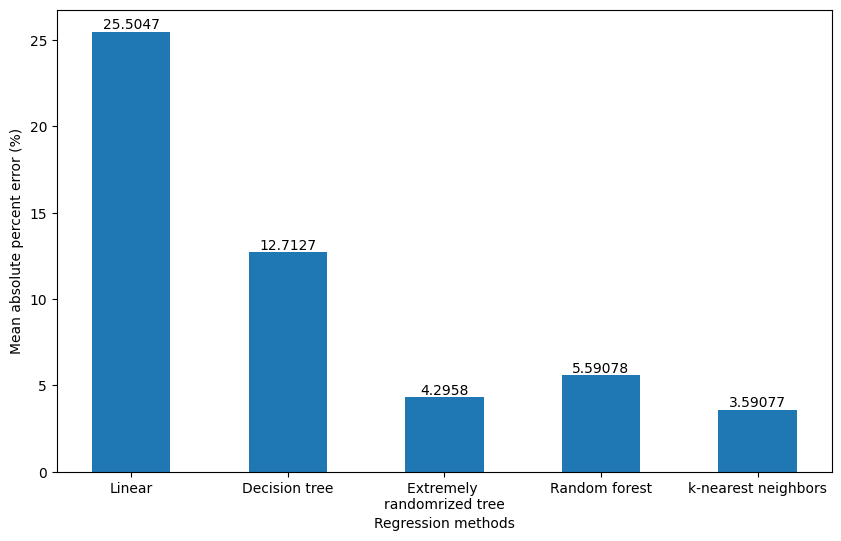

In [26]:
mape_t=np.zeros((10,5))
original_stdout = sys.stdout

for i in tqdm(range(10)):
    sys.stdout = open(os.devnull, 'w')

    mape=[]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mape.append(mean_absolute_percentage_error(y_test, y_pred))

    model = DecisionTreeRegressor()
    skf = KFold(n_splits=5, random_state=10, shuffle=True)
    model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
    model_search.fit(X_train, y_train)
    model = model_search.best_estimator_
    y_pred = model.predict(X_test)
    mape.append(mean_absolute_percentage_error(y_test, y_pred))

    model = ExtraTreeRegressor()
    model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
    model_search.fit(X_train, y_train)
    model = model_search.best_estimator_
    y_pred = model.predict(X_test)
    mape.append(mean_absolute_percentage_error(y_test, y_pred))

    model = RandomForestRegressor()
    model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
    model_search.fit(X_train, y_train)
    model = model_search.best_estimator_
    y_pred = model.predict(X_test)
    mape.append(mean_absolute_percentage_error(y_test, y_pred))

    model = KNeighborsRegressor()
    model_search = GridSearchCV(estimator=model, param_grid={'n_neighbors':np.arange(2,7), 'weights':['uniform', 'distance'], 'algorithm':['ball_tree', 'kd_tree', 'brute']}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
    model_search.fit(X_train, y_train)
    model = model_search.best_estimator_
    y_pred = model.predict(X_test)
    mape.append(mean_absolute_percentage_error(y_test, y_pred))

    mape_t[i]=mape
    sys.stdout = original_stdout

plt.figure(figsize = (10, 6))
bars=plt.bar(['Linear','Decision tree','Extremely \nrandomrized tree','Random forest','k-nearest neighbors'],np.mean(mape_t,axis=0)*100,width = 0.5)
plt.xlabel("Regression methods")
plt.ylabel("Mean absolute percent error (%)")
plt.bar_label(bars)
plt.show()

We can see that the tree regressors and k-nearest neighbors yield much better performance than the simple linear regressor, giving us the potential clue that in terms of handling limited small amount of data and noising data, they are significant better.
#
However, more time-series data are still needed in order to better verify these models and for better training and testing.